In [213]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from pgmpy.models import DiscreteBayesianNetwork 

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [214]:
df = pd.read_csv("dataset.csv")
df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [215]:
# Select relevant features

df = df[["ProductionVolume", "ProductionCost", "SupplierQuality", "DeliveryDelay", "DefectRate", "MaintenanceHours", "DefectStatus"]]

# Drop missing values for simplicity
df.dropna(inplace=True)

for column in ["ProductionVolume", "ProductionCost", "SupplierQuality", "DeliveryDelay", "DefectRate", "MaintenanceHours"]:
	df[column] = pd.cut(df[column], bins=3, labels=['low', 'medium', 'high'])

# Show preprocessed data
df.head()



,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,MaintenanceHours,DefectStatus
0,low,medium,low,low,medium,medium,1
1,medium,high,low,high,low,high,1
2,high,high,low,low,high,low,1
3,low,low,medium,high,low,medium,1
4,low,low,low,medium,high,medium,1


In [ ]:
# Manually define the structure
model = DiscreteBayesianNetwork ([
    ("ProductionCost", "DefectStatus"),
    ("MaintenanceHours", "DefectStatus"),
    ("DefectRate", "DefectStatus"),
    ("SupplierQuality", "DefectStatus"),
    ("ProductionVolume", "ProductionCost"),
		("DeliveryDelay", "SupplierQuality"),
])

In [217]:

# ## 6. Fit the Model
from pgmpy.estimators import MaximumLikelihoodEstimator

# Fit model using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ProductionVolume': 'O', 'ProductionCost': 'O', 'SupplierQuality': 'O', 'DeliveryDelay': 'O', 'DefectRate': 'O', 'MaintenanceHours': 'O', 'DefectStatus': 'N'}


In [218]:

# ## 7. Make Inference
from pgmpy.inference import VariableElimination

# Create inference object
inference = VariableElimination(model)


In [219]:

# Query: Probability of survival given Sex = female (0), Pclass = 1
query_result = inference.query(
    variables=["DefectStatus"],
    evidence={"DefectRate": 'low', "ProductionVolume": "high"}
)

print(query_result)


+-----------------+---------------------+
| DefectStatus    |   phi(DefectStatus) |
+=================+=====================+
| DefectStatus(0) |              0.2456 |
+-----------------+---------------------+
| DefectStatus(1) |              0.7544 |
+-----------------+---------------------+


In [220]:
print("Nodes:", list(model.nodes()))
print("Edges:", list(model.edges()))

Nodes: ['ProductionCost', 'DefectStatus', 'MaintenanceHours', 'DefectRate', 'SupplierQuality', 'ProductionVolume', 'DeliveryDelay']
Edges: [('ProductionCost', 'DefectStatus'), ('MaintenanceHours', 'DefectStatus'), ('DefectRate', 'DefectStatus'), ('SupplierQuality', 'DefectRate'), ('ProductionVolume', 'ProductionCost'), ('DeliveryDelay', 'SupplierQuality')]


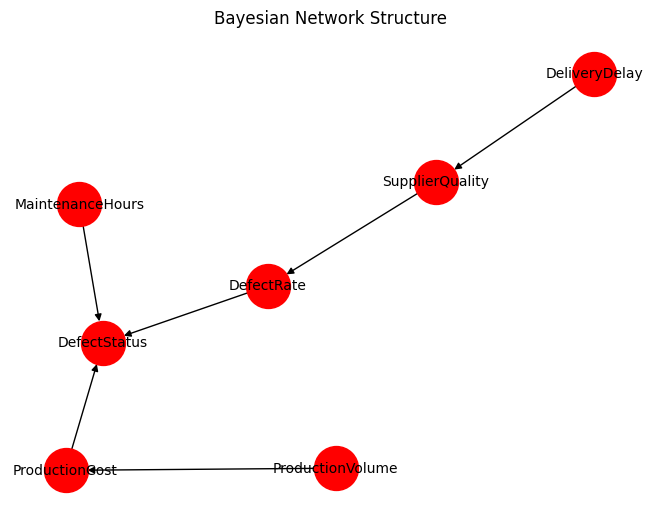

In [226]:
import matplotlib.pyplot as plt
import networkx as nx

# Створюємо окремий граф із тієї ж структури
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

# Отримуємо layout
pos = nx.spring_layout(G)

# Малюємо граф
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=1000,
    node_color='red',
    font_size=10,
    arrows=True
)
plt.title("Bayesian Network Structure")
plt.show()


In [222]:
from ipywidgets import interact_manual, widgets, Dropdown
from math import ceil
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
import matplotlib.pyplot as plt

# Список можливих категорій
levels = ['low', 'medium', 'high']

# Автоматичне створення dropdown'ів для всіх root-змінних
dropdowns = {}
root_variables = [var for var in model.nodes() if model.get_parents(var) == []]
for var in root_variables:
    dropdowns[var.lower()] = Dropdown(options=levels, description=f"{var}:")

@interact_manual(**dropdowns)
def compute_defect_status(**kwargs):
    evidence = {var: kwargs[var.lower()] for var in root_variables}

    try:
        result = inference.query(variables=["DefectStatus"], evidence=evidence)
        print("Inference Result:")
        print(result)
    except Exception as e:
        print("Inference failed:", e)
        return

    # 1. Візуалізація маргіналів
    cpds = model.get_cpds()
    fig = make_subplots(
        rows=ceil(len(cpds)/2), cols=2,
        subplot_titles=[cpd.variable for cpd in cpds],
        horizontal_spacing=0.15, vertical_spacing=0.2
    )

    row, col = 1, 1
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            states = cpd.state_names[variable]
            probs = marginal.values
        except:
            states = cpd.state_names[variable]
            probs = [0 for _ in states]

        decoded_states = [f"{variable} = {s}" for s in states]
        fig.add_trace(
            go.Bar(x=decoded_states, y=probs, name=variable),
            row=row, col=col
        )

        col += 1
        if col > 2:
            row += 1
            col = 1

    fig.update_layout(height=400*ceil(len(cpds)/2), width=900, title_text="Posterior Distributions given Evidence")
    fig.show()

    # 2. Табличний вивід
    print("Posterior Probabilities (Tabular):")
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            decoded_states = [f"{variable} = {s}" for s in cpd.state_names[variable]]
            df = pd.DataFrame({variable: decoded_states, "P(·|evidence)": marginal.values})
            display(df)
        except:
            continue

    # 3. Побудова графа
    G = nx.DiGraph()
    G.add_nodes_from(model.nodes())
    G.add_edges_from(model.edges())
    pos = nx.spring_layout(G)

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)

    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            states = cpd.state_names[variable]
            probs = marginal.values
            label = "\n".join([f"{s}: {p:.2f}" for s, p in zip(states, probs)])
            x, y = pos[variable]
            plt.text(x, y + 0.08, label, fontsize=8, ha='center',
                     bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        except:
            continue

    plt.title("Bayesian Network with Posterior Probabilities")
    plt.axis('off')
    plt.show()


interactive(children=(Dropdown(description='MaintenanceHours:', options=('low', 'medium', 'high'), value='low'…